Importamos las librerías

In [78]:
import csv
import numpy as np
import cv2
import sys
import matplotlib.pyplot as plt
from skimage.exposure import rescale_intensity
import skimage
from skimage.feature import graycomatrix, graycoprops
from skimage.feature import local_binary_pattern
import random
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, f1_score
from sklearn import preprocessing

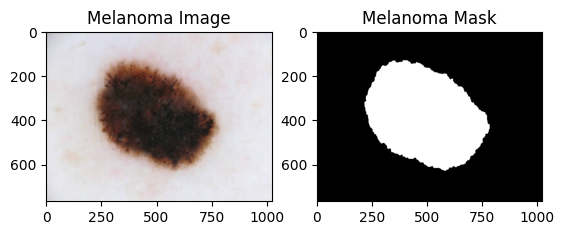

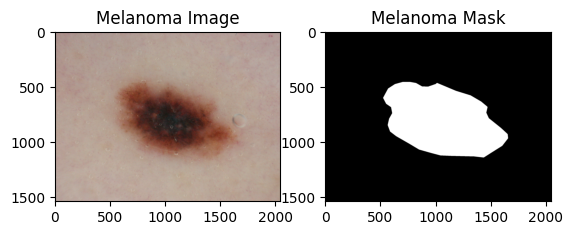

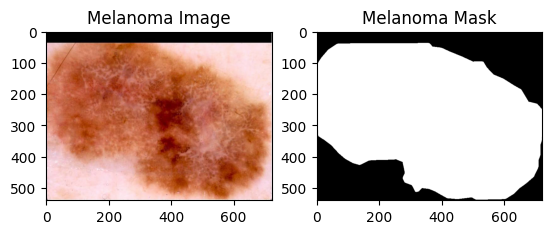

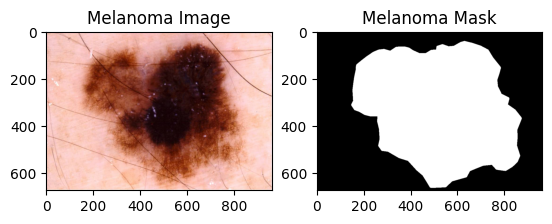

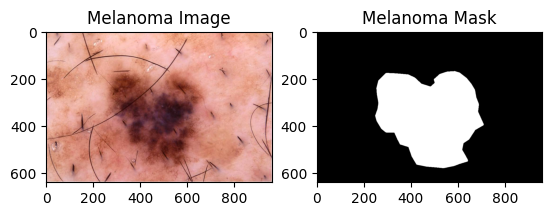

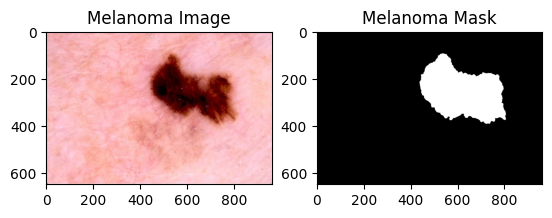

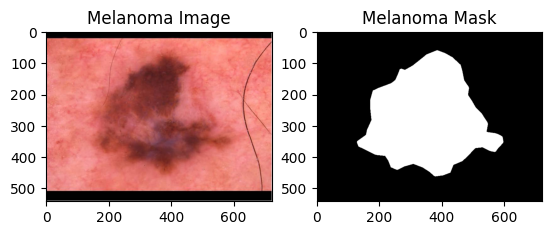

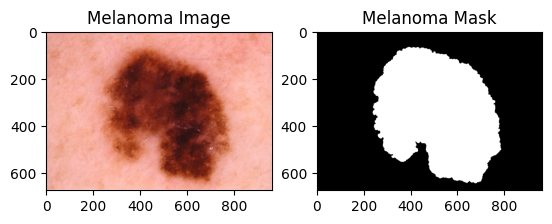

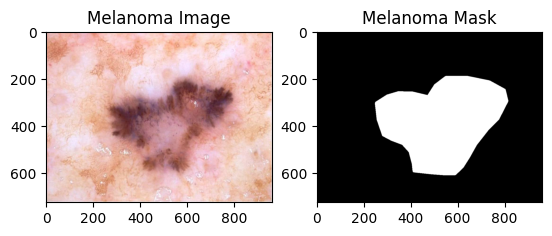

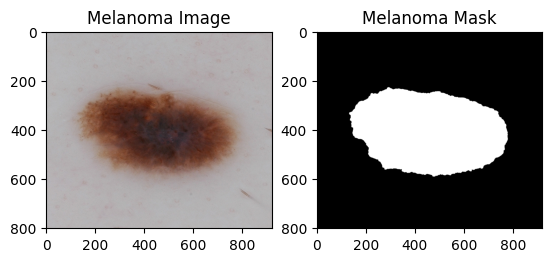

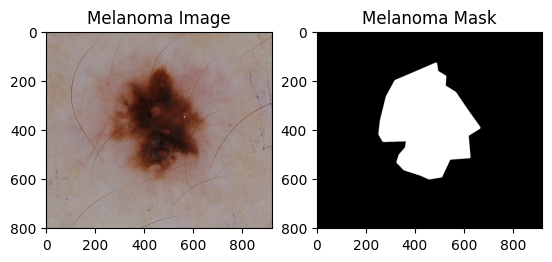

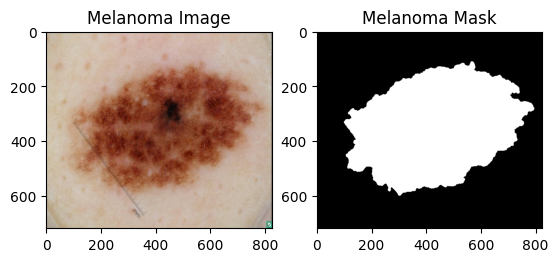

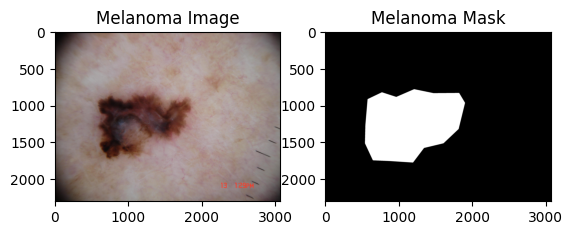

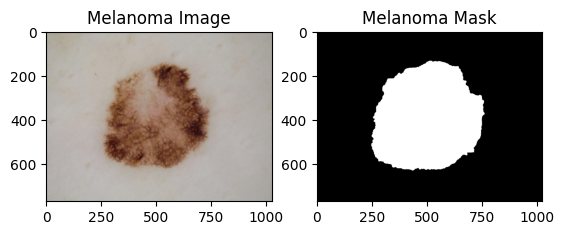

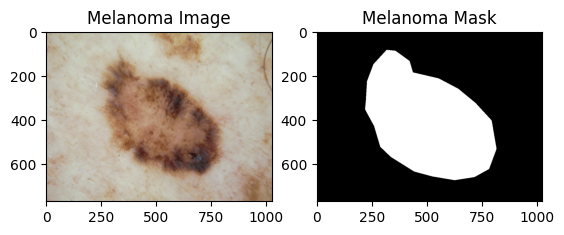

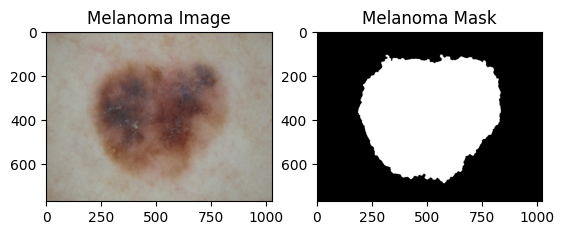

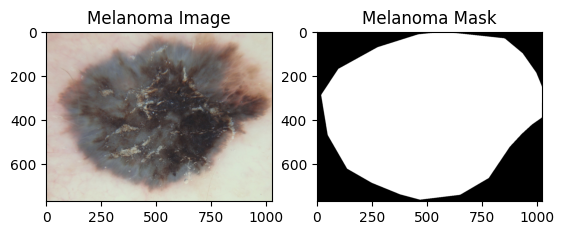

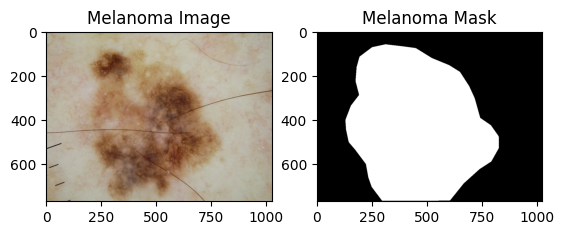

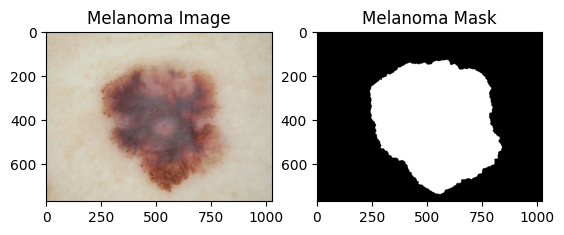

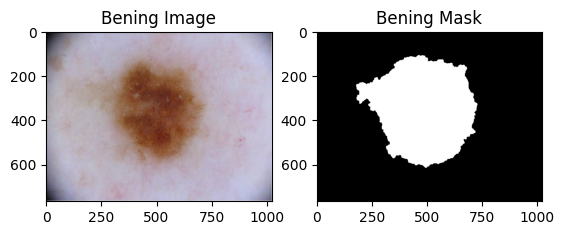

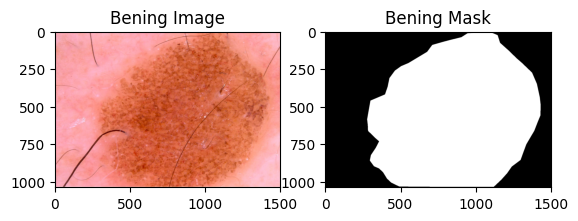

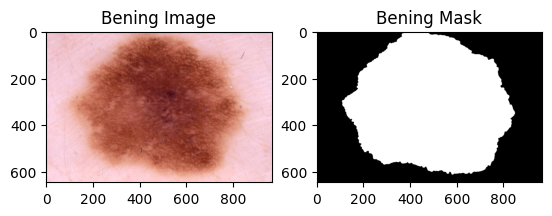

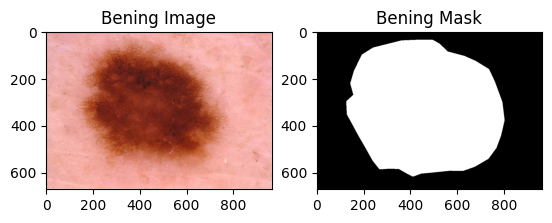

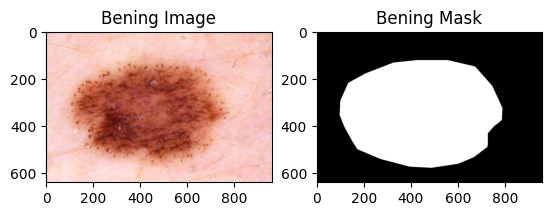

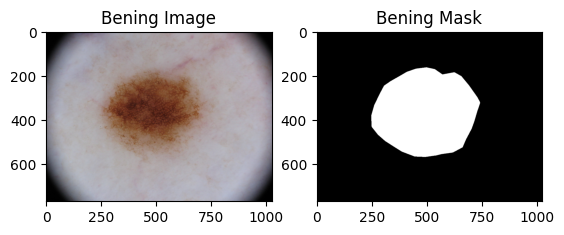

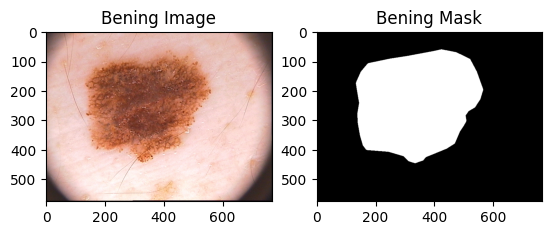

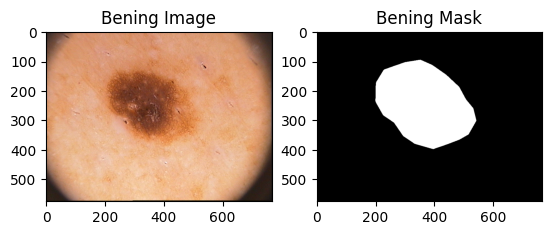

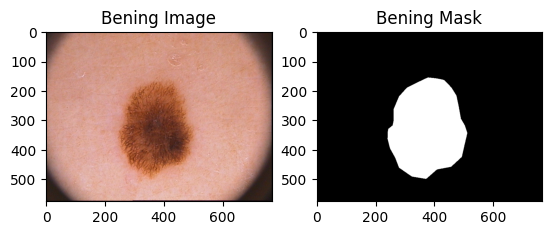

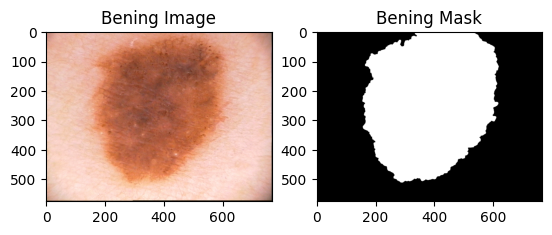

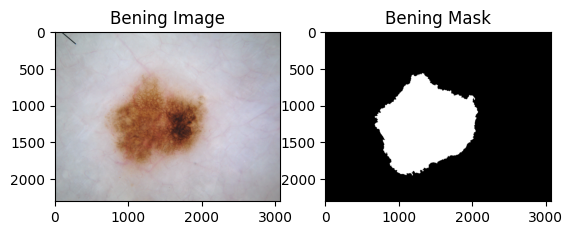

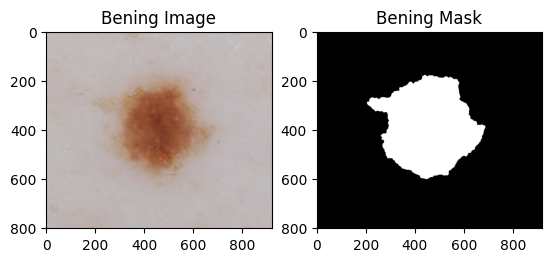

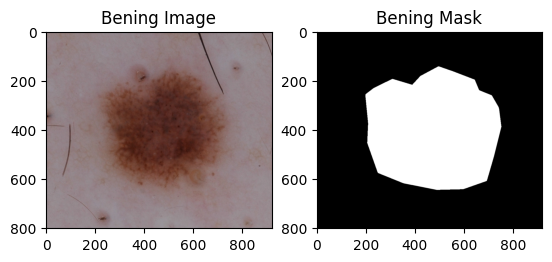

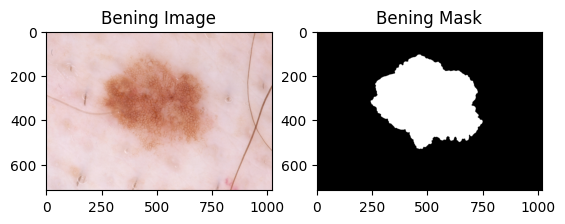

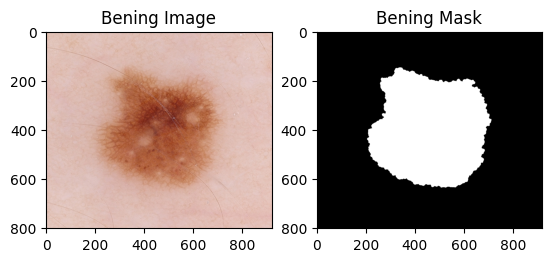

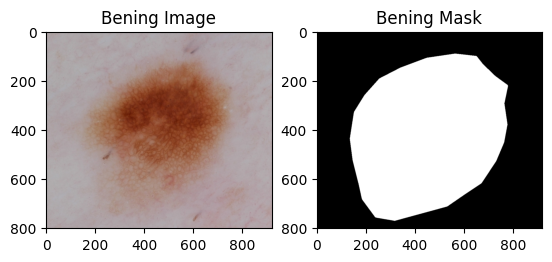

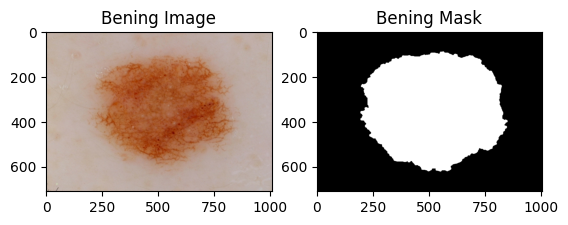

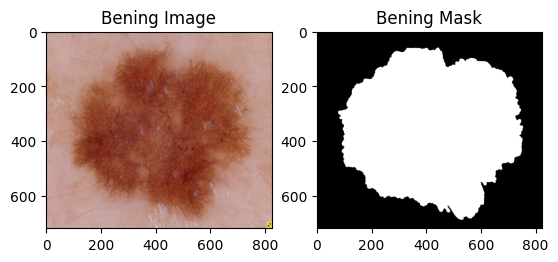

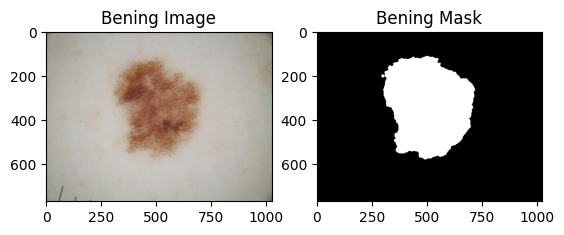

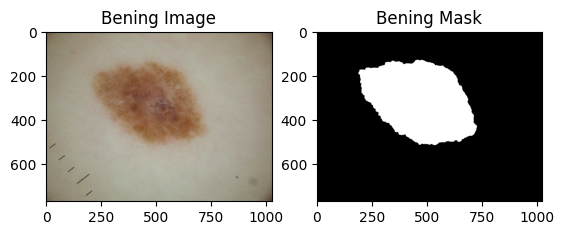

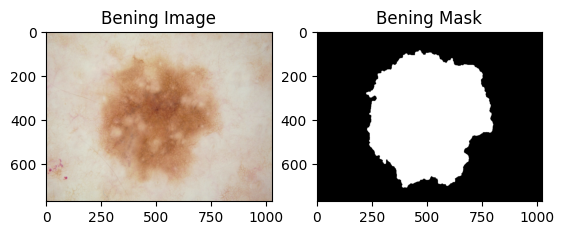

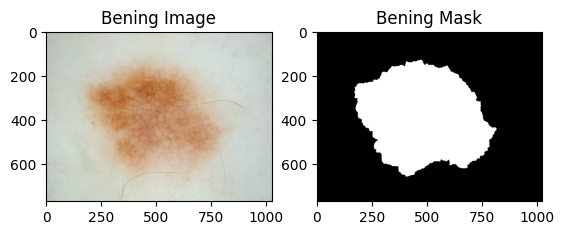

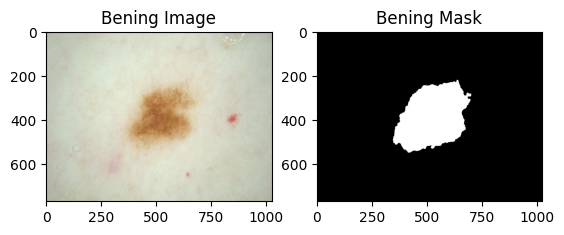

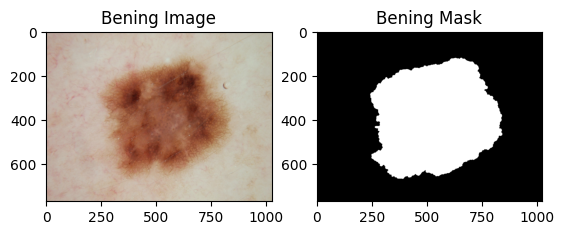

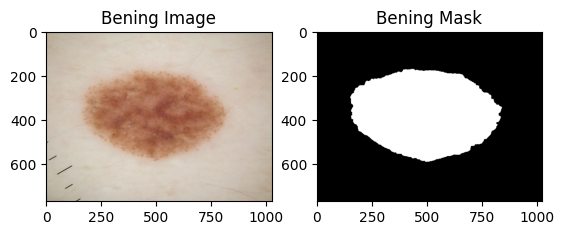

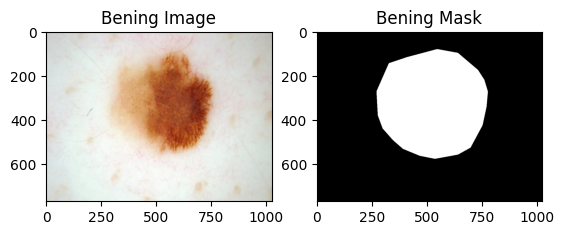

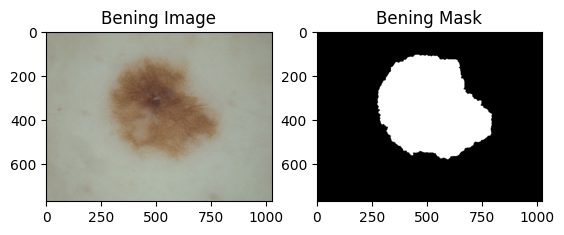

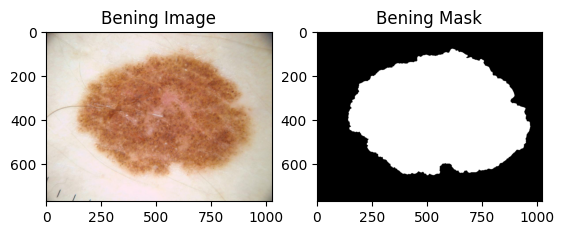

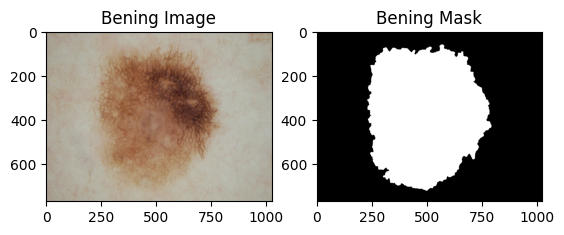

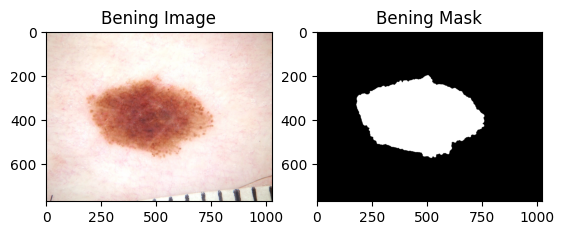

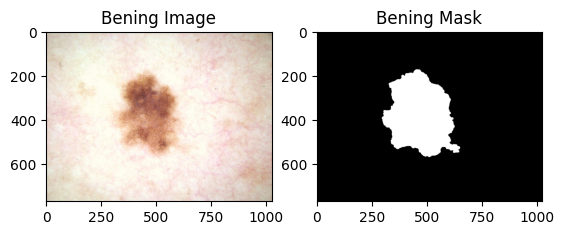

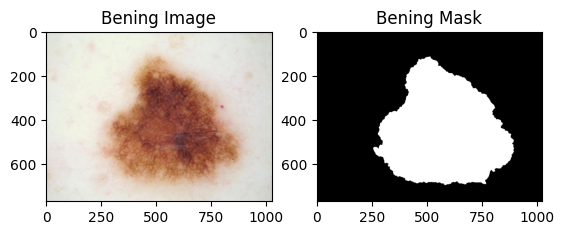

In [79]:
DATASET_DIR='./dataset/'
DATASET_FILE='./dataset/list.csv'


def read_csv(filename):
    data = dict()
    with open(filename, 'r') as f:
        reader = csv.reader(f)
        for row in reader:
            data[row[0]] = int(row[1])
        f.close()
    return data

def show(image, mask, cls):
    # Convertir la imagen de BGR a RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    win_title = "Melanoma" if cls else "Bening"
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(image_rgb)
    ax[1].imshow(mask, cmap='gray')
    ax[0].set_title(f"{win_title} Image")
    ax[1].set_title(f"{win_title} Mask")
    plt.show()

def normalize_image(image):
    # Asegurarse de que la imagen sea de tipo float32 para evitar problemas de precisión
    image = image.astype(np.float32)
    # Normalizar al rango [0, 1]
    image /= 255.0
    return image

def read_images(image_classes):
    images = []
    masks = []
    classes =  []
    for im in image_classes:
        images.append(cv2.imread(f"{DATASET_DIR}/images/{im}.jpg"))
        masks.append(cv2.imread(f"{DATASET_DIR}/masks/{im}_Segmentation.png", cv2.IMREAD_GRAYSCALE))
        classes.append(image_classes[im])
    return images, masks, classes

if __name__ == "__main__":

    image_classes = read_csv(DATASET_FILE)
    images, masks, classes = read_images(image_classes)

    for image, mask, image_class in zip(images, masks, classes):
        show(image, mask, image_class)

Tarea 1: Segmentación

In [80]:

segmentacion = []
img_np = []
contornos_im = []
kernel_p = cv2.getStructuringElement(1,(17,17))
kernel = np.ones((3,3),np.uint8)
kernel2 = np.ones((7,7),np.uint8)

for im in images:
    im = rescale_intensity(im, in_range='image', out_range=(0,255)).astype(np.uint8)
    ima = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
     # Eliminamos ruido
    
    # Para eliminar el pelo con blackhat
    blackhat = cv2.morphologyEx(ima, cv2.MORPH_BLACKHAT, kernel_p)
    _, umbral = cv2.threshold(blackhat,10,255,cv2.THRESH_BINARY)
    im_sinpelo = cv2.inpaint(im, umbral,1,cv2.INPAINT_TELEA)
    
    # Segmentación
    seg = cv2.cvtColor(im_sinpelo, cv2.COLOR_BGR2GRAY)
    seg[ seg < 10] = 255
    blur = cv2.medianBlur(seg, 15)
    _, otsu_thresh =cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    
    contours, _ = cv2.findContours(otsu_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # # Filtrar contornos por tamaño
    filtered_contours = [] 
    filtered_contours.append(max(contours, key=cv2.contourArea))


    # # Crear una copia de la imagen redimensionada para dibujar los contornos
    mask = np.zeros_like(ima)
    # # Dibujar los contornos en la copia de la imagen redimensionada
    cv2.drawContours(mask, filtered_contours, -1, 255, thickness = cv2.FILLED)

    dilate = cv2.dilate(mask,kernel,iterations=9)
    close = cv2.morphologyEx(dilate, cv2.MORPH_CLOSE, (9,9))
    dil = cv2.dilate(close ,kernel2,iterations=4)
    
    img_np.append(im_sinpelo)
    segmentacion.append(dil)



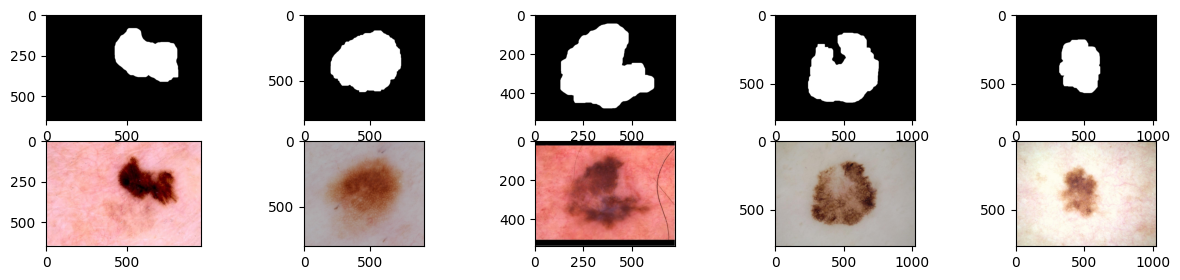

In [81]:
# Seleccionamos 5 imágenes aleatorias de la lista
selected_positions = random.sample(range(min(len(segmentacion), len(images))), 5)

# Configuramos la figura para mostrar las 5 imágenes
fig, ax = plt.subplots(2, 5, figsize=(15, 3))


for c in range(len(selected_positions)):
        ax[0,c].imshow(segmentacion[selected_positions[c]], cmap='gray')
        ima = images[selected_positions[c]] * 1
        ima = cv2.cvtColor(ima, cv2.COLOR_BGR2RGB)
        ax[1,c].imshow(ima, cmap='gray')
        #ax.axis('off')  # Ocultar los ejes para una visualización más limpia


Validación Estadística a través del índice de Jaccard

	 | Píxeles solapados = 192711
	 | Índice de Jaccard (%) =  87.93124689155462


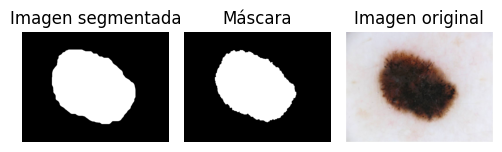

	 | Píxeles solapados = 458049
	 | Índice de Jaccard (%) =  84.76973044999029


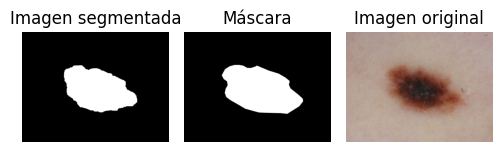

	 | Píxeles solapados = 275055
	 | Índice de Jaccard (%) =  92.35984258314082


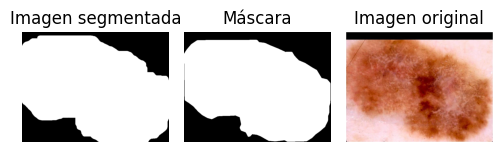

	 | Píxeles solapados = 289732
	 | Índice de Jaccard (%) =  88.91030165403382


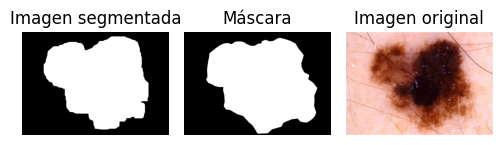

	 | Píxeles solapados = 130777
	 | Índice de Jaccard (%) =  85.10969236676493


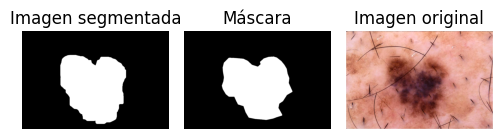

	 | Píxeles solapados = 68953
	 | Índice de Jaccard (%) =  76.86125447269566


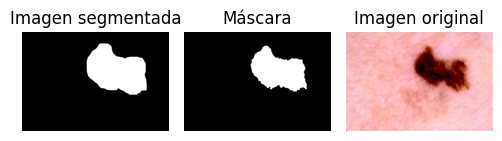

	 | Píxeles solapados = 106481
	 | Índice de Jaccard (%) =  75.78287357303499


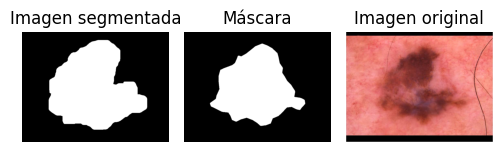

	 | Píxeles solapados = 225685
	 | Índice de Jaccard (%) =  91.63049789077503


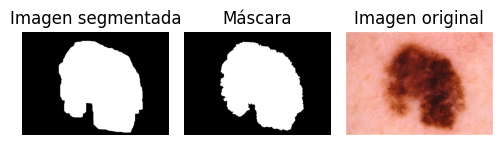

	 | Píxeles solapados = 154594
	 | Índice de Jaccard (%) =  89.18181451077896


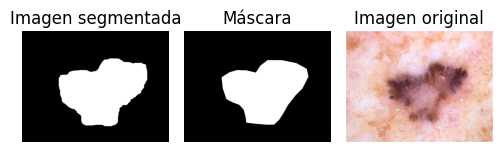

	 | Píxeles solapados = 173489
	 | Índice de Jaccard (%) =  92.37769163596089


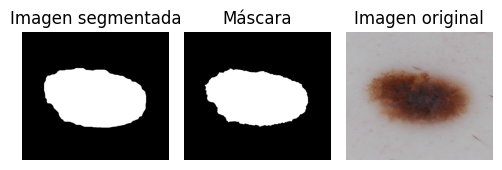

	 | Píxeles solapados = 121831
	 | Índice de Jaccard (%) =  89.21949147577479


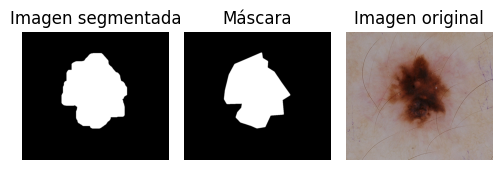

	 | Píxeles solapados = 213855
	 | Índice de Jaccard (%) =  89.74568802719376


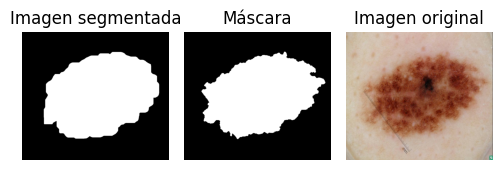

	 | Píxeles solapados = 853033
	 | Índice de Jaccard (%) =  82.14380290872182


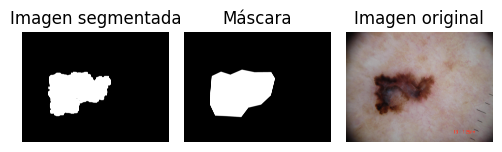

	 | Píxeles solapados = 178712
	 | Índice de Jaccard (%) =  85.76501866835594


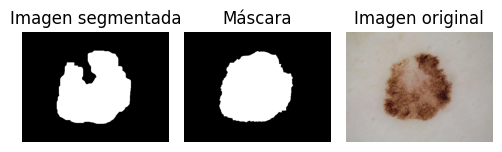

	 | Píxeles solapados = 216797
	 | Índice de Jaccard (%) =  90.0031966522333


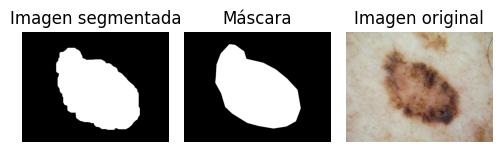

	 | Píxeles solapados = 248022
	 | Índice de Jaccard (%) =  87.42496395802564


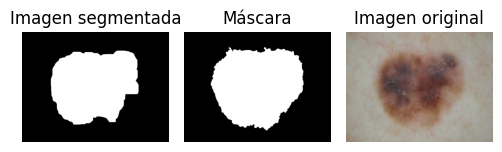

	 | Píxeles solapados = 492415
	 | Índice de Jaccard (%) =  86.68118350361571


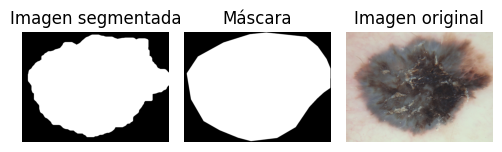

	 | Píxeles solapados = 241577
	 | Índice de Jaccard (%) =  67.77703273302677


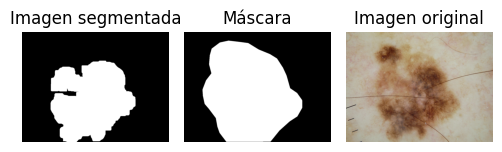

	 | Píxeles solapados = 250314
	 | Índice de Jaccard (%) =  93.93491346312614


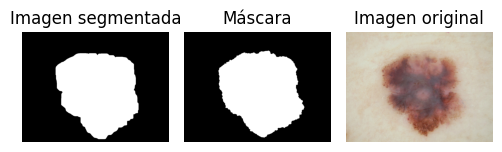

	 | Píxeles solapados = 163281
	 | Índice de Jaccard (%) =  87.11246978984938


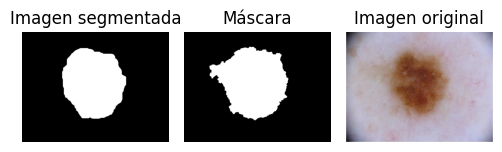

	 | Píxeles solapados = 888990
	 | Índice de Jaccard (%) =  96.18345387956917


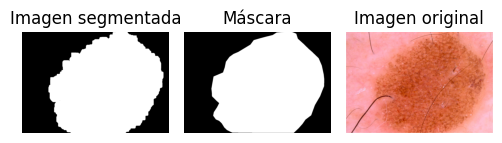

	 | Píxeles solapados = 320271
	 | Índice de Jaccard (%) =  95.43036944998168


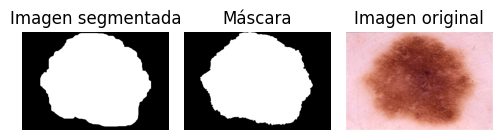

	 | Píxeles solapados = 240633
	 | Índice de Jaccard (%) =  78.46438283802554


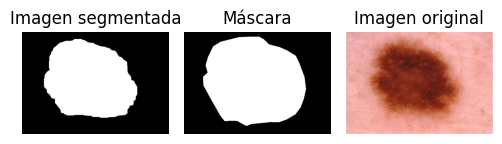

	 | Píxeles solapados = 228299
	 | Índice de Jaccard (%) =  91.42089435094084


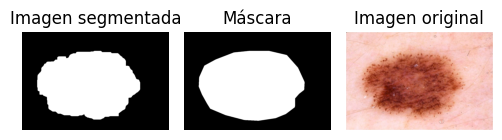

	 | Píxeles solapados = 130943
	 | Índice de Jaccard (%) =  86.13594353337412


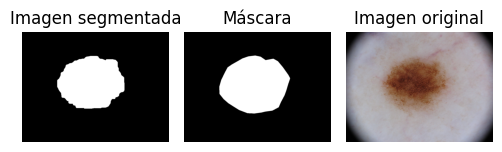

	 | Píxeles solapados = 122227
	 | Índice de Jaccard (%) =  92.30740184120894


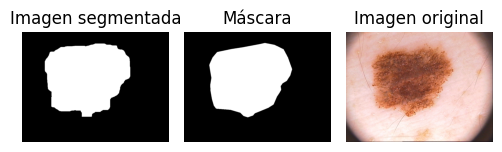

	 | Píxeles solapados = 55711
	 | Índice de Jaccard (%) =  75.44520130547242


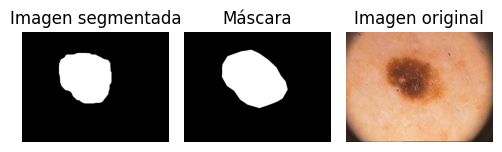

	 | Píxeles solapados = 66821
	 | Índice de Jaccard (%) =  91.91713550765506


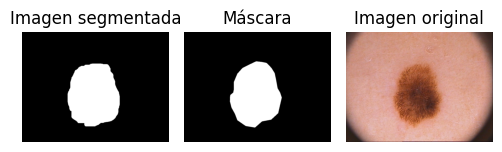

	 | Píxeles solapados = 183614
	 | Índice de Jaccard (%) =  90.29723030922968


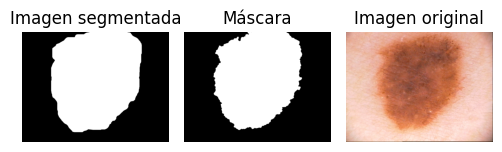

	 | Píxeles solapados = 945545
	 | Índice de Jaccard (%) =  76.46458495575293


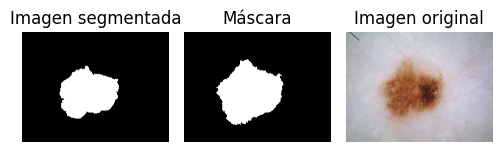

	 | Píxeles solapados = 106942
	 | Índice de Jaccard (%) =  84.80258827820819


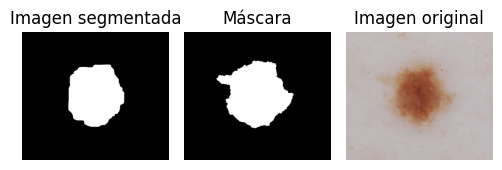

	 | Píxeles solapados = 198809
	 | Índice de Jaccard (%) =  87.61038938146693


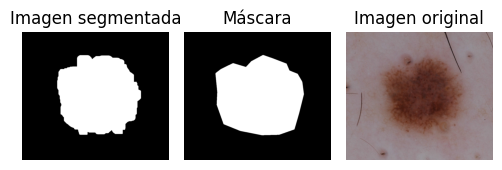

	 | Píxeles solapados = 134430
	 | Índice de Jaccard (%) =  84.59931278398007


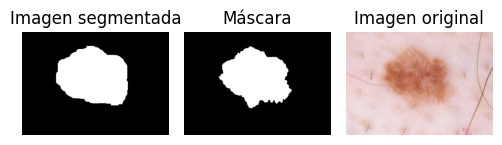

	 | Píxeles solapados = 180149
	 | Índice de Jaccard (%) =  94.09617031945345


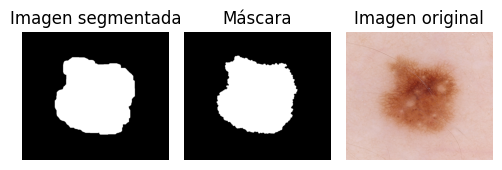

	 | Píxeles solapados = 186221
	 | Índice de Jaccard (%) =  55.977359080415546


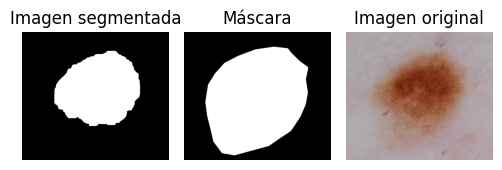

	 | Píxeles solapados = 244800
	 | Índice de Jaccard (%) =  93.19040077963211


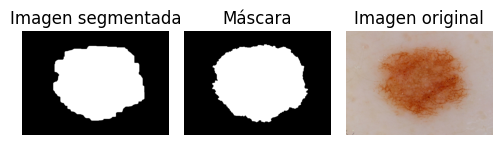

	 | Píxeles solapados = 297217
	 | Índice de Jaccard (%) =  92.08892331525948


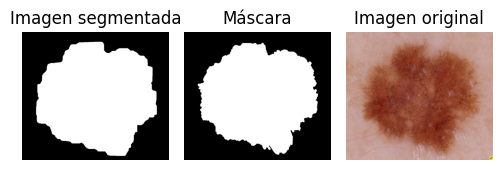

	 | Píxeles solapados = 138428
	 | Índice de Jaccard (%) =  94.40439737303336


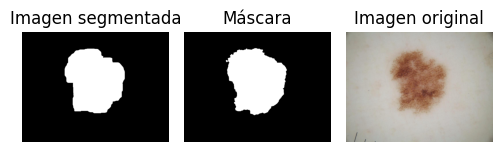

	 | Píxeles solapados = 144076
	 | Índice de Jaccard (%) =  91.54773856574616


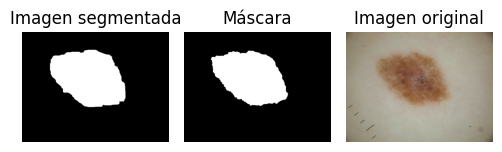

	 | Píxeles solapados = 221429
	 | Índice de Jaccard (%) =  87.23687580025609


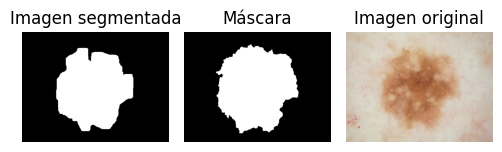

	 | Píxeles solapados = 205484
	 | Índice de Jaccard (%) =  89.58508630048


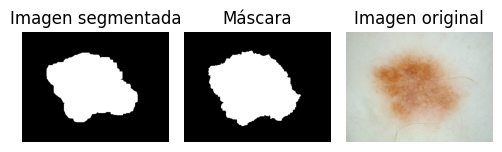

	 | Píxeles solapados = 68268
	 | Índice de Jaccard (%) =  87.16547497446373


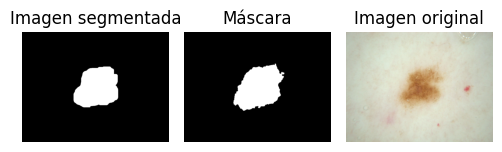

	 | Píxeles solapados = 231376
	 | Índice de Jaccard (%) =  94.0312033910015


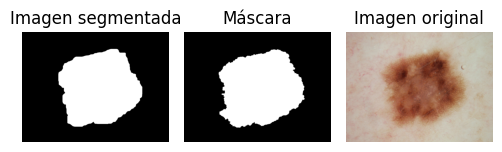

	 | Píxeles solapados = 204182
	 | Índice de Jaccard (%) =  94.93878651768983


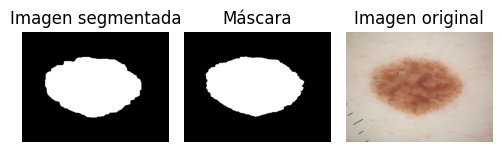

	 | Píxeles solapados = 134336
	 | Índice de Jaccard (%) =  68.2324258431532


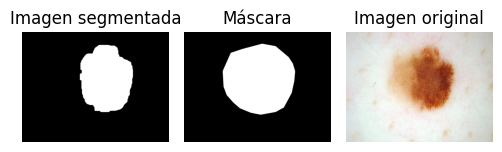

	 | Píxeles solapados = 166462
	 | Índice de Jaccard (%) =  93.73599270212742


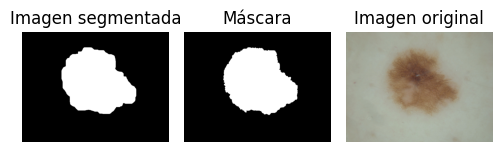

	 | Píxeles solapados = 335454
	 | Índice de Jaccard (%) =  91.22266004225915


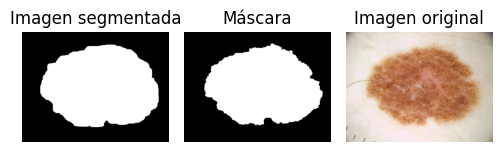

	 | Píxeles solapados = 234731
	 | Índice de Jaccard (%) =  82.88524011299435


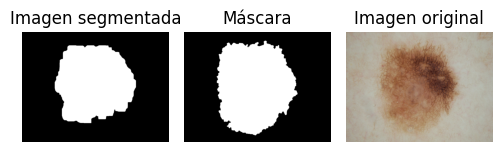

	 | Píxeles solapados = 139675
	 | Índice de Jaccard (%) =  90.86798688456334


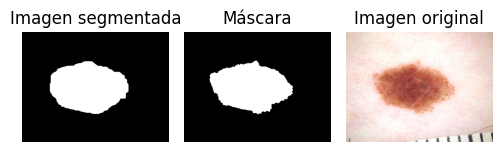

	 | Píxeles solapados = 85370
	 | Índice de Jaccard (%) =  87.68578148912786


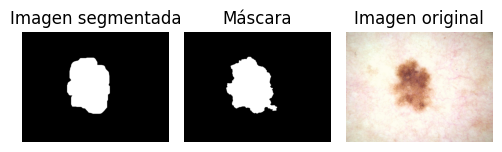

	 | Píxeles solapados = 234120
	 | Índice de Jaccard (%) =  94.04260276118593


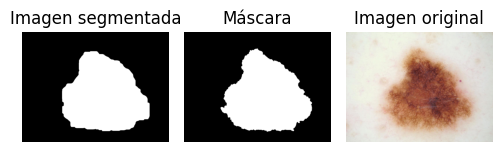

Promedio (Índice de Jaccard) 0.8703405297796787


In [82]:

# Seleccionamos 5 imágenes aleatorias de la lista
media = []

for i in range(len(masks)):
    ori = masks[i]
    segm = segmentacion [i]
    region_ori = (ori == 255)
    region_segm = (segm == 255)

    overlap = region_ori * region_segm
    overlap_px = np.sum(overlap) 

    print ("\t | Píxeles solapados =", overlap_px)
    union = region_ori | region_segm
    union_px = np.sum(union) 
    Jaccard = overlap_px / union_px
    print("\t | Índice de Jaccard (%) = ", Jaccard *100)
    f, ax = plt.subplots(1, 3, figsize=(5, 10))
    for a in ax: a.axis('off')  
    ax[0].set_title("Imagen segmentada")      
    ax[0].imshow(region_segm, cmap = "gray")
    ax[1].set_title("Máscara")      
    ax[1].imshow(region_ori, cmap = "gray")
    ima = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)
    ax[2].set_title("Imagen original")      
    ax[2].imshow(ima)
    
    media.append(Jaccard)

    plt.tight_layout()
    plt.show()

print("Promedio (Índice de Jaccard)", np.sum(media)/len(media))

Extracción de Características

In [83]:

def ext_caracteristicas(imagen, seg_con):
    imagen_g = cv2.cvtColor(imagen.astype(np.uint8), cv2.COLOR_BGR2GRAY)

    ## Filtros de Gabor
    # Cramos un banco de filtros
    filters = []
    ksize = 31
    
    for theta in np.arange(0, np.pi, np.pi / 16):
        kern = cv2.getGaborKernel((ksize, ksize), 4.0, theta, 10.0, 0.5, 0, ktype=cv2.CV_32F)
        kern /= 1.5*kern.sum()
        filters.append(kern)
    imagen_norm = imagen_g.astype(float)/255.0
    feature_vector_Gabor = []
    for index,f in enumerate(filters):
        conv = cv2.filter2D(imagen_norm, -1, f)
        # Calcular estadísticas para el vector
        mean = np.mean(conv)
        var = np.var(conv)
        feature_vector_Gabor.append(mean)
        feature_vector_Gabor.append(var)
            
        # Distribucion de colores de la imagen
        histogram, _ = np.histogram(conv, 100)
        # Probabilidades de ocurrencia de cada color
        histogram = histogram.astype(float)/ (conv.shape[0]*conv.shape[1])

        H = -np.sum(histogram*np.log2(histogram + np.finfo(float).eps))
        feature_vector_Gabor.append(H)
    feature_vector_Gabor = np.reshape(feature_vector_Gabor, (1,48))

    ## Matriz de co-ocurrencia: Contraste, energía, homogeneidad

    cm = graycomatrix(imagen_g, [1, 2], [0, np.pi/4, np.pi/2, 3*np.pi/4], normed=True, symmetric=True)
    contraste = graycoprops(cm, 'contrast')
    homog = graycoprops(cm, 'homogeneity')
    corr = graycoprops(cm, 'correlation')

    # Concatenación
    feature_vector_ocu = np.concatenate((contraste, homog, corr), axis = 0)
    feature_vector_ocu = np.reshape(feature_vector_ocu, (1, feature_vector_ocu.shape[0]*feature_vector_ocu.shape[1]))

    ## Local Binary Patterns
    lbp = local_binary_pattern(imagen_g, 8, 5)
    feature_vector_lbp, _  = np.histogram(lbp, 256, density=True) 

    feature_vector_lbp = np.reshape(feature_vector_lbp, (1,256))
    
    
    ## Formas 
    label, numlabel = cv2.connectedComponents(imagen_g)
    zona_mel = label == 1
    # Crear una máscara para la región más grande
    area = np.sum(zona_mel)

    ## Colores
    hist_color = cv2.calcHist([imagen], [0, 1, 2], None, [8, 8, 8], [1, 256, 1, 256, 1, 256])
    hist_color = hist_color.flatten()
    mean_c = np.mean(imagen)  # media colores
    var_c = np.var(imagen)  # varianza colores
    vector_color = np.reshape(np.array([mean_c, var_c, area]), (1,3))
    hist_vector_c = np.reshape(hist_color, (1,512))

    feature_vector = np.concatenate((feature_vector_Gabor, hist_vector_c, feature_vector_ocu, feature_vector_lbp, vector_color), axis=1)
    return feature_vector

feature_vectors = []

for i in range(len(images)): 
    ima = img_np[i] * 1
    ima = cv2.cvtColor(ima, cv2.COLOR_BGR2RGB)
    resultado = cv2.bitwise_and(ima, ima, mask = segmentacion[i])

    vector = ext_caracteristicas(resultado, segmentacion[i])
    feature_vectors.append(vector)
    print(f"\nVectores de características imagen {i}:", vector[0][0:20])



Vectores de características imagen 0: [0.04525342 0.01759896 1.85431792 0.04525341 0.0165012  1.95137109
 0.04525342 0.01585628 1.99110835 0.04525342 0.01609194 1.8738848
 0.04525342 0.01450868 1.98902246 0.04525342 0.01440195 1.95183543
 0.04525342 0.01457671]

Vectores de características imagen 1: [0.02759845 0.00668534 1.23933148 0.02759845 0.00634361 1.2662414
 0.02759846 0.00599838 1.27456467 0.02759845 0.00589865 1.27314951
 0.02759845 0.00587714 1.2774702  0.02759846 0.00629133 1.27119253
 0.02759846 0.00677047]

Vectores de características imagen 2: [0.21398531 0.02970853 3.61658272 0.21390069 0.02796058 3.71691707
 0.21379748 0.02644883 3.77564622 0.21378003 0.02655532 3.75671268
 0.21378937 0.02696019 3.65967199 0.21379929 0.03029509 3.67367091
 0.21382115 0.03374029]

Vectores de características imagen 3: [0.07908453 0.02815012 2.89769361 0.07908453 0.02473615 2.85427175
 0.07908454 0.02091404 3.02361029 0.07908453 0.01911402 3.02939702
 0.07908453 0.01843078 2.83705057 0.0

In [84]:
#feature_vectors_array = np.array(feature_vectors)
feature_vectors_array = np.concatenate(feature_vectors, axis=0)

# Conservar las columnas que no son completamente 0
non_zero_columns = np.any(feature_vectors_array != 0, axis=0)

feature_vectors_array = feature_vectors_array[:, non_zero_columns]

Tarea 2: Clasificación

En esta ocasión se realizó un modelo de SVM

In [85]:

data = feature_vectors_array
data = feature_vectors_array.astype(np.float32)
print(type(data), data.dtype == np.float32)
data = preprocessing.normalize(data) #normalizamos
labels = np.array(classes).astype(np.int32)  # etiquetas
print(type(labels), labels.dtype == np.int32)
labels = labels.reshape((labels.shape[0], 1)).astype(np.int32)


print(data.shape, labels.shape)


<class 'numpy.ndarray'> True
<class 'numpy.ndarray'> True
(51, 476) (51, 1)


In [143]:

def clasificadores(data, labels):
    indices = np.arange(0, data.shape[0]) # Todos los indices del vector
    np.random.shuffle(indices) # Aleatorizar los indices del vector
    #print indices.shape, indices

    k = 10 # k de la k-fold
    step = int(data.shape[0] / k) # Numero de ejemplos usados en cada fold (2000)

    # Guardamos los resultados de tres modelos: KNN, Arboles y SVM
    results_KNN = []
    results_Trees = []
    results_SVM = []

    print("\n CLASIFICADORES \n")
    
    for c in range(3):
        print(f"ITERACIÓN {c}:\n")
        print("CLASIFICADOR \t ACIERTOS / TOTAL \t PORCENAJE")
        for i in range(k):
            print(f"FOLD {i}\n")
            # Indices para test
            test_idx = indices[i*step:(i+1)*step]
            #print i, "test", test_idx.shape, test_idx
            
            # Indices para entrenamiento    
            train_idx_a = indices[:i*step] 
            train_idx_b = indices[(i+1)*step:]
            train_idx = np.concatenate([train_idx_a, train_idx_b])
            #print i, "train", train_idx.shape, train_idx
            
            # Obtener el conjunto de entrenamiento a partir de los índices
            train_data_k = data[train_idx]
            train_labels_k = labels[train_idx]

            # Obtener el conjunto de test a partir de los índices
            test_data_k = data[test_idx]
            test_labels_k = labels[test_idx]


            ## ENTRENAMIENTO PARA KNN ##
            knn = cv2.ml.KNearest_create()
            # Entrenamos el clasificador
            knn.train(train_data_k, cv2.ml.ROW_SAMPLE, train_labels_k)

            # Validamos el clasificador con el conjunto de test
            ret, results, neighbours, dist = knn.findNearest(test_data_k, 3)
            # Comprobamos resultados para los tres primeros ejemplos del conjunto de test
            #results = results.flatten()
            success = np.sum(results == test_labels_k)

            cm = confusion_matrix(test_labels_k, results)
            # Extraer los valores de la matriz de confusión
            TN, FP, FN, TP = cm.ravel()

            

            print(f"KNN {i+1} \t\t\t {success}/{test_labels_k.shape[0]} \t\t {100*float(success)/float(test_labels_k.shape[0])}%")

            especificidad = TN / (TN + FP)
            sensibilidad = recall_score(test_labels_k, results)
            accuracy = accuracy_score(test_labels_k, results)
            f1score = f1_score(test_labels_k, results)
            results_KNN.append([sensibilidad, especificidad, accuracy, success, f1score])

            ## ENTRENAMIENTO PARA TREES ##
            rt = cv2.ml.RTrees_create()
            rt.setMaxDepth(100)

            rt.train(train_data_k, cv2.ml.ROW_SAMPLE, train_labels_k)
            ret, results = rt.predict(test_data_k)
            #results = results.flatten()
            success = np.sum(results == test_labels_k)

            cm = confusion_matrix(test_labels_k, results)
            # Extraer los valores de la matriz de confusión
            TN, FP, FN, TP = cm.ravel()

            

            print(f"Trees {i+1} \t\t {success}/{test_labels_k.shape[0]} \t\t {100*float(success)/float(test_labels_k.shape[0])}%")

            especificidad = TN / (TN + FP)
            sensibilidad = recall_score(test_labels_k, results)
            accuracy = accuracy_score(test_labels_k, results)
            f1score = f1_score(test_labels_k, results)
            results_Trees.append([sensibilidad, especificidad, accuracy, success, f1score])

            ## ENTRENAMIENTO PARA SVM ##
            svm = cv2.ml.SVM_create()
            svm.train(train_data_k, cv2.ml.ROW_SAMPLE, train_labels_k)
            ret, results = svm.predict(test_data_k)
            

            success=np.sum(results==test_labels_k)

            cm = confusion_matrix(test_labels_k, results)
            # Extraer los valores de la matriz de confusión
            TN, FP, FN, TP = cm.ravel()

            print(f"SVM {i+1} \t\t\t {success}/{test_labels_k.shape[0]} \t\t {100*float(success)/float(test_labels_k.shape[0])}%")

            especificidad = TN / (TN + FP)
            sensibilidad = recall_score(test_labels_k, results)
            accuracy = accuracy_score(test_labels_k, results)
            f1score = f1_score(test_labels_k, results)
            results_SVM.append([sensibilidad, especificidad, accuracy, success, f1score])
            print("---------------------------------------------------------------------")
    return results_SVM, results_KNN, results_Trees


results_SVM, results_KNN, results_Trees = clasificadores(data, labels)

print("\nCOMPARACIÓN DE MODELOS:\n")
results_KNN_array = np.vstack(results_KNN)
results_Trees_array = np.vstack(results_Trees)
results_SVM_array = np.vstack(results_SVM)

print("--------------------")
print("CLASIFICADOR \t ACIERTOS/TOTAL \t % ACIERTO \t SENSIBILIDAD \t ESPECIFICIDAD \t Accuracy")
print(f" Modelo KNN \t {np.sum(results_KNN_array[:,3]):.2f}/{len(results_KNN_array)*5:.2f} \t\t {100*(np.sum(results_KNN_array[:,3])/150):.2f}% \t\t {np.mean(results_KNN_array[:,0]):.2f} \t\t {np.mean(results_KNN_array[:,1]):.2f} \t\t {np.mean(results_KNN_array[:,2]):.2f}")
print(f" Modelo Tree \t {np.sum(results_Trees_array[:,3]):.2f}/{len(results_Trees_array)*5:.2f} \t\t {100*(np.sum(results_Trees_array[:,3])/150):.2f}% \t\t {np.mean(results_Trees_array[:,0]):.2f} \t\t {np.mean(results_Trees_array[:,1]):.2f} \t\t {np.mean(results_Trees_array[:,2]):.2f}")
print(f" Modelo SVM \t {np.sum(results_SVM_array[:,3]):.2f}/{len(results_SVM_array)*5:.2f} \t\t {100*(np.sum(results_SVM_array[:,3])/150):.2f}% \t\t {np.mean(results_SVM_array[:,0]):.2f} \t\t {np.mean(results_SVM_array[:,1]):.2f} \t\t {np.mean(results_SVM_array[:,2]):.2f}")




 CLASIFICADORES 

ITERACIÓN 0:

CLASIFICADOR 	 ACIERTOS / TOTAL 	 PORCENAJE
FOLD 0

KNN 1 			 3/5 		 60.0%
Trees 1 		 4/5 		 80.0%
SVM 1 			 3/5 		 60.0%
---------------------------------------------------------------------
FOLD 1

KNN 2 			 5/5 		 100.0%
Trees 2 		 5/5 		 100.0%
SVM 2 			 5/5 		 100.0%
---------------------------------------------------------------------
FOLD 2

KNN 3 			 4/5 		 80.0%
Trees 3 		 3/5 		 60.0%
SVM 3 			 5/5 		 100.0%
---------------------------------------------------------------------
FOLD 3

KNN 4 			 3/5 		 60.0%
Trees 4 		 5/5 		 100.0%
SVM 4 			 4/5 		 80.0%
---------------------------------------------------------------------
FOLD 4

KNN 5 			 3/5 		 60.0%
Trees 5 		 3/5 		 60.0%
SVM 5 			 3/5 		 60.0%
---------------------------------------------------------------------
FOLD 5

KNN 6 			 4/5 		 80.0%
Trees 6 		 5/5 		 100.0%
SVM 6 			 5/5 		 100.0%
---------------------------------------------------------------------
FOLD 6

KNN 7 			 5/5 		 100